In [12]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from tensorflow.keras.models import load_model
from data_lib import Data
import numpy as np
import tensorflow
from tensorflow.keras import layers, losses
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint 

In [2]:
Data_for_clustering = Data('chinese-word-list.txt')

In [3]:
Data_for_clustering.drawings(20)

100%|█████████████████████████████████████████████████████████████████████████| 163500/163500 [03:57<00:00, 688.15it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


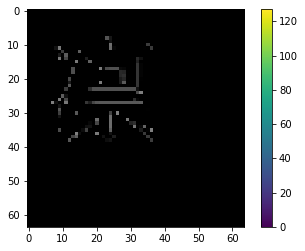

凛


In [4]:
num = np.random.randint(0, len(Data_for_clustering.X_data))
fig = plt.figure()
plt.imshow(Data_for_clustering.X_data[101])
plt.colorbar()
plt.grid(False)
plt.show()

print(Data_for_clustering.Y_data[101])

In [5]:
 Data_for_clustering.lable()

In [6]:
def identity_block(X, f, filters, stage, block):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters 
    X_shortcut = X
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    X = Conv2D(filters = F2, kernel_size = (f,f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    X = Conv2D(filters = F3, kernel_size = (1,1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X) 
    return X

In [7]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters
    X_shortcut = X
    X = Conv2D(F1, (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    X = Conv2D(filters = F2, kernel_size = (f,f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    X = Conv2D(filters = F3, kernel_size = (1,1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    return X

In [8]:
def ResNet50(input_shape = (64, 64, 3), classes = 8193):
    X_input = Input(input_shape)
    X = ZeroPadding2D((3, 3))(X_input)
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')
    X = AveragePooling2D((2, 2), name = 'avg_pool')(X)
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    model = Model(inputs = X_input, outputs = X, name='ResNet50')
    return model

In [9]:
model = ResNet50(input_shape = (64, 64, 3), classes = len(Data_for_clustering.letters))

In [10]:
optimizer = tensorflow.keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9)

In [11]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
filepath_to_raw_model="resnet50_model.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath_to_raw_model, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

callbacks_list = [checkpoint]

In [15]:
model.fit( Data_for_clustering.X_data,  Data_for_clustering.Y_classes, epochs = 100, batch_size = 32,validation_split = 0.1, callbacks=callbacks_list,)

Epoch 1/100
4599/4599 [==============================] - ETA: 0s - loss: 9.0070 - accuracy: 4.0775e-04
Epoch 00001: val_loss improved from inf to 8.59491, saving model to resnet50_model.hdf5
4599/4599 [==============================] - 8846s 2s/step - loss: 9.0070 - accuracy: 4.0775e-04 - val_loss: 8.5949 - val_accuracy: 7.9511e-04
Epoch 2/100
4599/4599 [==============================] - ETA: 0s - loss: 8.0704 - accuracy: 0.0028
Epoch 00002: val_loss improved from 8.59491 to 7.18613, saving model to resnet50_model.hdf5
4599/4599 [==============================] - 33506s 7s/step - loss: 8.0704 - accuracy: 0.0028 - val_loss: 7.1861 - val_accuracy: 0.0084
Epoch 3/100
4599/4599 [==============================] - ETA: 0s - loss: 6.1419 - accuracy: 0.0337
Epoch 00003: val_loss improved from 7.18613 to 4.65986, saving model to resnet50_model.hdf5
4599/4599 [==============================] - 9251s 2s/step - loss: 6.1419 - accuracy: 0.0337 - val_loss: 4.6599 - val_accuracy: 0.1064
Epoch 4/100
4

KeyboardInterrupt: 